In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

# Load dataset
df = pd.read_csv('data/train.csv')
  # Make sure train.csv is in the same folder
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tulsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
target
0    4342
1    3271
Name: count, dtype: int64


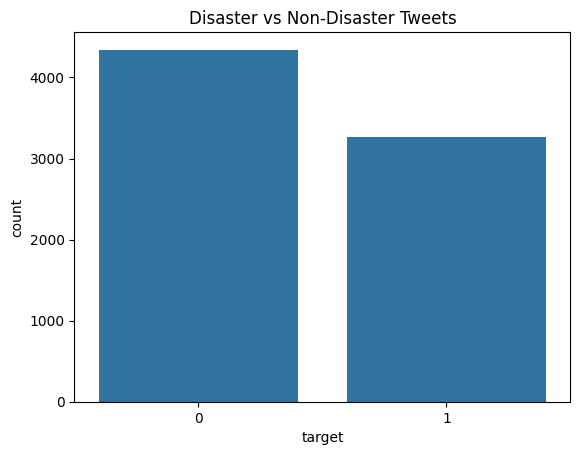

In [3]:

df.info()
print(df['target'].value_counts())

sns.countplot(x='target', data=df)
plt.title('Disaster vs Non-Disaster Tweets')
plt.show()
# Preprocessing function

In [4]:

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


In [5]:

X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [6]:

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8003939592908733
              precision    recall  f1-score   support

           0       0.80      0.88      0.83       874
           1       0.81      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [7]:

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

# Compare
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_nb)
    ]
})
results


,Model,Accuracy
0,Logistic Regression,0.800394
1,Random Forest,0.774130
2,Naive Bayes,0.799737


In [9]:
# Logistic Regression - speed up
param_grid_lr = {
    'C': [1],  # try only the default-ish value for now
    'solver': ['liblinear']  # pick one fast solver
}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=200),
    param_grid_lr,
    cv=2,  # 2-fold instead of 3
    scoring='accuracy',
    n_jobs=-1  # use all cores
)
grid_lr.fit(X_train_tfidf, y_train)
print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best Logistic Regression Accuracy:", grid_lr.best_score_)

# Random Forest - speed up
param_dist_rf = {
    'n_estimators': [50, 100],  # fewer trees
    'max_depth': [None, 10],
    'min_samples_split': [2]
}
random_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=2,  # fewer combinations
    cv=2,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_rf.fit(X_train_tfidf, y_train)
print("Best Random Forest Params:", random_rf.best_params_)
print("Best Random Forest Accuracy:", random_rf.best_score_)


Best Logistic Regression Params: {'C': 1, 'solver': 'liblinear'}
Best Logistic Regression Accuracy: 0.7848932676518883
Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Best Random Forest Accuracy: 0.7729064039408867


In [10]:

final_model = grid_lr.best_estimator_
y_pred_final = final_model.predict(X_test_tfidf)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))


Final Model Accuracy: 0.8017071569271176
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       874
           1       0.81      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [13]:

import os
os.makedirs('models', exist_ok=True)

with open('models/disaster_tweet_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("✅ Model and vectorizer saved!")


✅ Model and vectorizer saved!
